In [55]:
if "descended" not in locals():
    descended = 1
    %cd ".."
    
import utils

import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import pickle

from simulations import lightcurve_simulation as lcsim
import visualize as vis
from detection import rnn_detection as rnndet
from detection import rnn_monodetection as mono
from dataloading import loading as dl
from tqdm import tqdm

from wotan import flatten
from sklearn.metrics import mean_squared_error

In [2]:
rnn_conf = torch.load("models/bigru1conf_w4sqrt_sim.pt")
rnn_ = torch.load("models/bigru1_w4sqrt_sim.pt")

## Illustration of application

In [3]:
np.random.seed(206)
# np.random.seed(0)
success = False
while not success:
    lc = lcsim.get_lightcurve(num_planets=1, min_transits=1, period_range=(2,100), t_max=27.4, 
                          max_attempts=4, max_snr_attempts=10, snr_range=(3,80), 
                          rdepth_range=(.5,5.), dur_range=(0,utils.hour2day(13)))
    time, flux, pl_masks, params = lc
    success = params["planets"][0]["pl_transits"] == 1
mask = pl_masks[0]

mean, std = -0.10192371859533564, 2.6337997430623323
flux_ = ((flux-1) / params["sigma"] - mean) / std

pts_conf, conf_conf = rnndet.get_pts(rnn_conf, flux_.reshape(1,-1), additional=True)
pts_ = rnndet.get_pts(rnn_, flux_.reshape(1,-1), additional=False)

standard_det_conf, conf_det_conf = mono.monotransit_detection(pts_conf, conf_conf, peak_thresh=0.5)
standard_det_, conf_det_ = mono.monotransit_detection(pts_, peak_thresh=0.5)

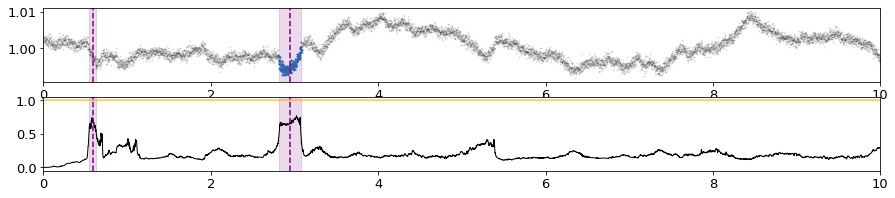

In [4]:
conf_model = 0
if conf_model:
    standard_det, conf_det = standard_det_conf, conf_det_conf
    pts, conf = pts_conf, conf_conf
else:
    standard_det, conf_det = standard_det_, conf_det_
    pts, conf = pts_, np.ones_like(pts_)

plt.figure(figsize=(15,3))
plt.subplot(2,1,1)
vis.plot(time[~mask], flux[~mask], c="black", a=0.1)
for msk in pl_masks:
    vis.plot(time[msk], flux[msk], c=plt.plot([])[0].get_color(), a=1)
for detection in standard_det:
    t0 = standard_det[detection]["t0"]
    dur = standard_det[detection]["duration"]
    plt.axvspan(t0-0.5*dur, t0+0.5*dur, color="purple", alpha=0.15)
    plt.axvline(t0, color="purple", alpha=1, linestyle="--")
# plt.xlim(0,time[-1])
plt.xlim(0,10)

plt.subplot(2,1,2)
vis.plot(time, pts, scatter=0)
vis.plot(time, conf, scatter=0, c="orange")
for detection in standard_det:
    t0 = standard_det[detection]["t0"]
    dur = standard_det[detection]["duration"]
    plt.axvspan(t0-0.5*dur, t0+0.5*dur, color="purple", alpha=0.15)
    plt.axvline(t0, color="purple", alpha=1, linestyle="--")
# plt.xlim(0,time[-1])
plt.xlim(0,10)
plt.show()

In [5]:
standard_det, conf_det

({0.68550605: {'t0': 0.5888888888888889, 'duration': 0.08194444444444438},
  0.7305853: {'t0': 2.95, 'duration': 0.25972222222222197}},
 {0.68550605: {'t0': 0.5888888888888889, 'duration': 0.08194444444444438},
  0.7305853: {'t0': 2.95, 'duration': 0.25972222222222197}})

## Detect transits and store results

In [6]:
rnn_conf = torch.load("models/bigru1conf_w4sqrt_sim.pt")
rnn_ = torch.load("models/bigru1_w4sqrt_sim.pt")

In [12]:
# mean, std = -0.10192371859533564, 2.6337997430623323  # obtained from training set
# fnames = [fnm for fnm in os.listdir("data/eval/sim/monotransit") if not fnm.startswith(".")]

# rnn_.to("cpu")
# rnn_conf.to("cpu")

# detections = {}
# pbar = tqdm(fnames)
# for fname in pbar:
#     try:
#         batch = dl.load_data("data/eval/sim/monotransit/"+fname)
#         if batch is None:
#             continue
#         sigma = np.array([batch["meta"][i]["sigma"] for i in batch["sampleid"]])
#         flux_ = ((batch["flux"]-1) / sigma[:,None] - mean) / std
  
#         flux_in = flux_.reshape(-1,flux_.shape[-1])
#         pts_ = np.zeros_like(flux_in)
#         pts_c, conf_c = np.zeros_like(flux_in), np.zeros_like(flux_in)

#         step = 50
#         for i in range(step, len(flux_in)+1, step):
#             pts_[i-step:i] = rnndet.get_pts(rnn_, flux_in[i-step:i], additional=False)
#             rnn_.to("cpu")
#             pts_c[i-step:i], conf_c[i-step:i] = rnndet.get_pts(rnn_conf, flux_in[i-step:i], additional=True)
#             rnn_conf.to("cpu")

#         for i, sampleid in enumerate(batch["sampleid"]):
#             standard_det_c, conf_det_c = mono.monotransit_detection(pts_c[i], conf_c[i], peak_thresh=0.5)
#             standard_det_, conf_det_ = mono.monotransit_detection(pts_[i], peak_thresh=0.5)
#             detections[sampleid] = {"std_det_c":standard_det_c,
#                               "conf_det_c":conf_det_c,
#                               "std_det_":standard_det_}
#     except:
#         pbar.close()
#         raise

## Results

In [62]:
with open("results/rnn_monodetections.pkl", "rb") as f:
    detections = pickle.load(f)
    
best_only = 1

if best_only:
    for i in detections:
        for mname in detections[i]:
            if len(list(detections[i][mname].keys())):
                mx = np.max(list(detections[i][mname].keys()))
                detections[i][mname] = {mx:detections[i][mname][mx]}

In [63]:
meta = {}
fnames = [fnm for fnm in os.listdir("data/eval/sim/monotransit") if not fnm.startswith(".")]
for fname in fnames:
    batch = dl.load_data("data/eval/sim/monotransit/"+fname)
    if batch is None:
        continue
    meta = {**meta, **batch["meta"]}

In [64]:
def correct_detection(params, detection):
    # assumes sample (params) contains single planet (&  single transit)
    if params["planets"] == {}:
        print("sample contains no planets")
        raise Exception
    t0_true = params["planets"][0]["pl_t0"]
    dur_true = params["planets"][0]["pl_duration"]
    correct = (detection["t0"] > (t0_true - 0.5*dur_true)) and (detection["t0"] < (t0_true + 0.5*dur_true))
    return correct

In [65]:
thresholds = np.linspace(0.5,1,100)
snames = ["tp", "fp", "fn", "tn"]
mnames = ['std_det_c', 'conf_det_c', 'std_det_']

std_c = {sname:[] for sname in snames}
conf_c = {sname:[] for sname in snames}
std_ = {sname:[] for sname in snames}

pbar = tqdm(thresholds)
for thr in pbar:  
    try:
        for dic, mname in zip([std_c, conf_c, std_], mnames):
            tp = fp = tn = fn = 0
            for i in meta:

                fp += np.sum(np.array(list(detections[i][mname].keys())) >= thr)
                tn += np.sum(np.array(list(detections[i][mname].keys())) < thr)

                if meta[i]["planets"] != {}:
                    for score, det in detections[i][mname].items():
                        correct = correct_detection(meta[i], det)
                        if score >= thr and correct:
                            tp += 1
                            fp -= 1
                            break # can only have one correct detection
                        if score < thr and correct:
                            fn += 1
                            tn -= 1
                            break
            if mname == "std_det_c":
                std_c["tp"].append(tp), std_c["fp"].append(fp)
                std_c["tn"].append(tn), std_c["fn"].append(fn)

            elif mname == 'conf_det_c':
                conf_c["tp"].append(tp), conf_c["fp"].append(fp)
                conf_c["tn"].append(tn), conf_c["fn"].append(fn)

            elif mname == 'std_det_':
                std_["tp"].append(tp), std_["fp"].append(fp)
                std_["tn"].append(tn), std_["fn"].append(fn)
    except:
        pbar.close()
        raise

100%|██████████| 100/100 [00:54<00:00,  1.85it/s]


In [66]:
for sname in snames:
    std_c[sname] = np.array(std_c[sname])
    conf_c[sname] = np.array(conf_c[sname])
    std_[sname] = np.array(std_[sname])

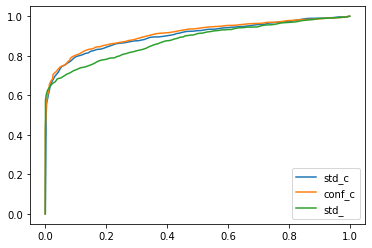

In [67]:
def get_fpr(dic):
    return dic["fp"] / (dic["fp"] + dic["tn"]) 
    
def get_tpr(dic):
    return dic["tp"] / (dic["tp"] + dic["fn"]) 
    
mnames = ["std_c", "conf_c", "std_"]
for dic, mname in zip([std_c, conf_c, std_], mnames):
    plt.plot(get_fpr(dic), get_tpr(dic), label=mname)
plt.legend()

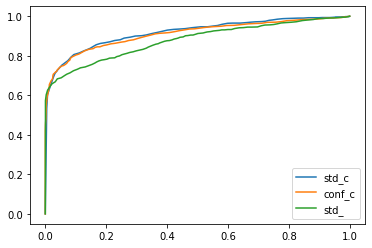

In [47]:
def get_fpr(dic):
    return dic["fp"] / (dic["fp"] + dic["tn"]) 
    
def get_tpr(dic):
    return dic["tp"] / (dic["tp"] + dic["fn"]) 
    
mnames = ["std_c", "conf_c", "std_"]
for dic, mname in zip([std_c, conf_c, std_], mnames):
    plt.plot(get_fpr(dic), get_tpr(dic), label=mname)
plt.legend()

In [36]:
for mname in detections[0]:
    n = 0
    for i in detections:
        n += len(detections[i][mname])
    print(mname, n)

std_det_c 4937
conf_det_c 4937
std_det_ 14856


#### BLS mono transit detection [TODO]

In [318]:
def get_monobox(time, t0, duration, depth):
    box = np.zeros_like(time)
    box[(time>=t0-duration/2.) & (time<=t0+duration/2.)] = -depth
    return box

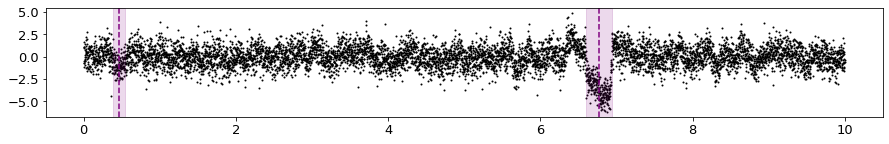

In [374]:
flat = (flatten(time, flux, method="median", window_length=1)-1)/params["sigma"]
plt.figure(figsize=(15,2))
vis.plot(time, flat)
for detection in standard_det:
    t0 = standard_det[detection]["t0"]
    dur = standard_det[detection]["duration"]
    plt.axvspan(t0-0.5*dur, t0+0.5*dur, color="purple", alpha=0.15)
    plt.axvline(t0, color="purple", alpha=1, linestyle="--")

In [405]:
# durations = np.arange(1.,14,2)/24.
# step = 20
# depths = np.array([0.25,0.5,1,2,5]) / params["sigma"]

# snrs = np.zeros_like(time)
# mses = np.zeros_like(time) + 1e9
# t0s = np.zeros_like(time)
# durs = np.zeros_like(time)


# for duration in durations:   
#     dur_n = int(utils.day2min(duration)/2.)
#     indc = np.arange(dur_n)-step
#     for i in range(int((len(time)-dur_n)/step)+1):  
#         indc += step
#         score_indc = np.arange(step, dtype=int)+int(np.median(indc))-int(step/2.)
#         for depth in depths:
#             fit = np.zeros(len(time))
#             fit[indc] = depth
#             mse = mean_squared_error(flat, fit)
#             if mse < np.mean(mses[score_indc]):
#                 snr = depth * np.sqrt(dur_n)
#                 mses[score_indc] = mse
#                 snrs[score_indc] = snr
#                 t0s[score_indc] = time[score_i]
#                 durs[score_indc] = duration   